=== Processing Waypoint = Falklands ===
=== Processing Waypoint = SouthGeorgia ===


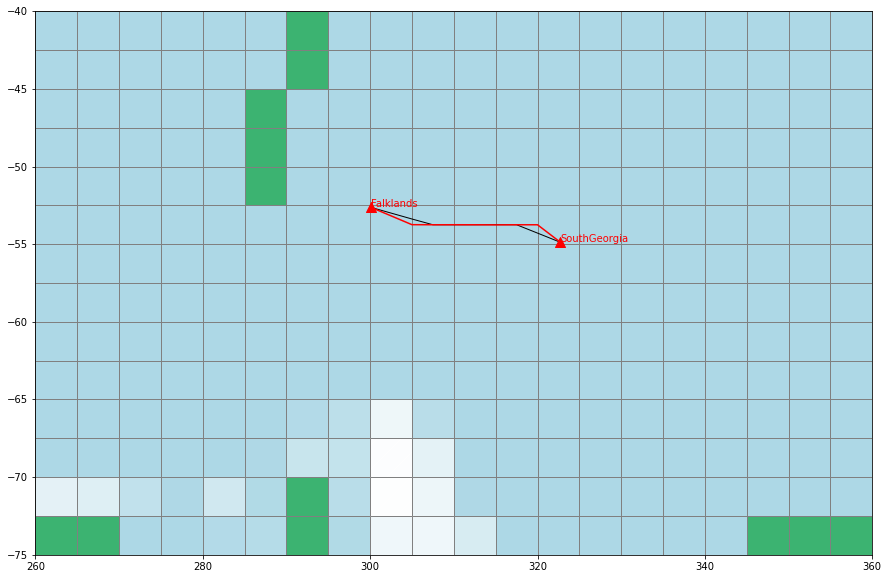

In [1]:
import pandas as pd
from RoutePlanner.CellGrid import CellGrid

#read in Ice  & Currents Points
icePoints     = pd.read_json('../resources/icepoints2019-02-08.json')
icePoints     = pd.DataFrame.from_records(icePoints.icepoints)
currentPoints = pd.read_json('../resources/currentPoints.json')
currentPoints = pd.DataFrame.from_records(currentPoints.currentPoints)

longMin    = 260
longMax    = 360
latMin     = -75
latMax     = -40
cellWidth  = 5
cellHeight = 2.5

cellGrid = CellGrid(longMin, longMax, latMin, latMax, cellWidth, cellHeight)
cellGrid.addIcePoints(icePoints)
cellGrid.addCurrentPoints(currentPoints)

from RoutePlanner.Optimisation import TravelTime
OptInfo = {}
OptInfo['WayPoints']            = pd.read_csv('../resources/WayPoints_TestExample2.csv') 
OptInfo['MaxIceExtent']         = 0.8
OptInfo['VehicleInfo']          = {}
OptInfo['VehicleInfo']['Speed'] = 26.3 #Units km/hr

TT = TravelTime(cellGrid,OptInfo)
TT.Dijkstra(verbrose=True)



In [2]:
from RoutePlanner.Function import NewtonianCurve

In [43]:
import numpy as np
from tqdm import tqdm

Path = TT.Paths[1]


startPoint = Path['Path']['FullPath'][0,:][None,:]
endPoint   = Path['Path']['FullPath'][-1,:][None,:]

OrgcrossingPoints = np.concatenate([startPoint,
                                 Path['Path']['CrossingPoints'],
                                 endPoint])

ax.scatter(OrgcrossingPoints[:,0],OrgcrossingPoints[:,1],15,'b')
ax.plot(OrgcrossingPoints[:,0],OrgcrossingPoints[:,1],'b')

Points = OrgcrossingPoints.copy()
iter=0
for iter in tqdm(range(50)):
    for id in range(Points.shape[0]-2):
        Sp  = tuple(Points[id,:])
        Cp  = tuple(Points[id+1,:])
        Np  = tuple(Points[id+2,:])
        nc = NewtonianCurve(TT.Mesh,Sp,Cp,Np,TT.OptInfo['VehicleInfo']['Speed'],debugging=1,maxiter=4)
        TravelTime, CrossingPoint = nc.value()

        #Points[id+1,:] = CrossingPoint

        if id == 0:
            newPoints = CrossingPoint
        else:
            newPoints = np.concatenate([newPoints,CrossingPoint])

    Points = np.concatenate([startPoint,newPoints,endPoint])


 46%|████▌     | 23/50 [00:00<00:00, 227.72it/s]

========= Longitude Case ========= 
------- x=302512.04;a=552870.00;CrossingPoint=(320.00,-54.48);
--- Number of Iterations=3: y=36330.77; F=31719605115178.81250; dF=16633541996.58
------- Box1 (cx,cy)=(322.74,-54.88); Box2 (cx,cy)=(317.50,-53.75)
------- y=36330.77;x=302512.04;a=552870.00;Y=124879.52;u1=-0.00723;v1=0.04827;u2=-0.02506;v2=0.06135;s=7.31
------ TravelTime=58734.07;CrossPoints=[320.00,-54.55]
========= Longitude Case ========= 
------- x=552870.00;a=552870.00;CrossingPoint=(315.00,-54.02);
--- Number of Iterations=3: y=19971.19; F=87716060684284.90625; dF=35699935805.88
------- Box1 (cx,cy)=(317.50,-53.75); Box2 (cx,cy)=(312.50,-53.75)
------- y=19971.19;x=552870.00;a=552870.00;Y=60339.94;u1=-0.02506;v1=0.06135;u2=-0.04063;v2=0.13786;s=7.31
------ TravelTime=85942.74;CrossPoints=[315.00,-54.11]
========= Longitude Case ========= 
------- x=552870.00;a=552870.00;CrossingPoint=(310.00,-53.56);
--- Number of Iterations=3: y=11403.31; F=89784594274604.04688; dF=35557619429.6

100%|██████████| 50/50 [00:00<00:00, 263.16it/s]


------- Box1 (cx,cy)=(312.50,-53.75); Box2 (cx,cy)=(307.50,-53.75)
------- y=52525.99;x=552870.00;a=552870.00;Y=124253.31;u1=-0.04063;v1=0.13786;u2=-0.11052;v2=0.12839;s=7.31
------ TravelTime=87070.34;CrossPoints=[310.00,-54.08]
========= Longitude Case ========= 
------- x=552870.00;a=539601.12;CrossingPoint=(305.00,-53.35);
--- Number of Iterations=3: y=71727.09; F=78406451146104.45312; dF=33468654077.28
------- Box1 (cx,cy)=(307.50,-53.75); Box2 (cx,cy)=(300.12,-52.63)
------- y=71727.09;x=552870.00;a=539601.12;Y=160887.79;u1=-0.11052;v1=0.12839;u2=-0.04793;v2=0.07985;s=7.31
------ TravelTime=88857.77;CrossPoints=[305.00,-53.44]
========= Longitude Case ========= 
------- x=302512.04;a=552870.00;CrossingPoint=(320.00,-54.76);
--- Number of Iterations=3: y=3575.87; F=35758489758440.34375; dF=15789617706.37
------- Box1 (cx,cy)=(322.74,-54.88); Box2 (cx,cy)=(317.50,-53.75)
------- y=3575.87;x=302512.04;a=552870.00;Y=36585.66;u1=-0.00723;v1=0.04827;u2=-0.02506;v2=0.06135;s=7.31
-----

(-60.0, -50.0)

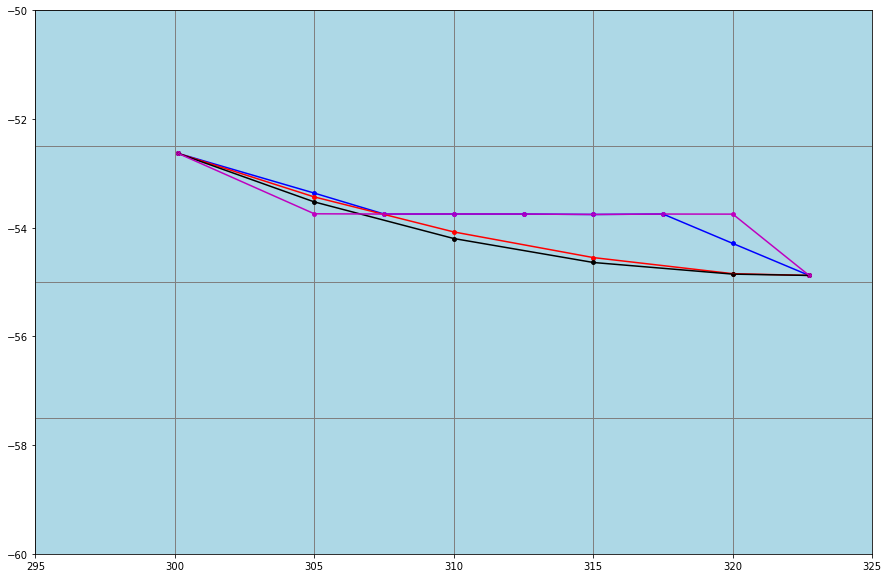

In [44]:
ax = cellGrid.plot(return_ax=True)

crossingPoints = np.concatenate([Path['Path']['FullPath'][0,:][None,:],
                                 Path['Path']['CrossingPoints'],
                                 Path['Path']['FullPath'][-1,:][None,:]])


ax.scatter(Path['Path']['FullPath'][:,0],Path['Path']['FullPath'][:,1],15,'b')
ax.plot(Path['Path']['FullPath'][:,0],Path['Path']['FullPath'][:,1],'b')

ax.scatter(Points[:,0],Points[:,1],15,'r')
ax.plot(Points[:,0],Points[:,1],'r')


ax.scatter(305.00,-33.47)

# Loading Ground Truth & Comparing
GT = pd.read_csv('../resources/TestExample_GroundTruth2_Smooth.csv')
GT['Long'] = GT['Long']+360
ax.plot(GT['Long'],GT['Lat'],'k')
ax.scatter(GT['Long'],GT['Lat'],15,'k')

GT = pd.read_csv('../resources/TestExample_GroundTruth2.csv')
GT['Long'] = GT['Long']+360
ax.plot(GT['Long'],GT['Lat'],'m')
ax.scatter(GT['Long'],GT['Lat'],15,'m')



ax.set_xlim([295,325])
ax.set_ylim([-60,-50])